This model will still be a variational autoencoder, but I will use a CNN within the architecture. 

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics

import csv

In [2]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_channels=2, input_length=200, h_dim=128, z_dim=20):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=3, stride=2, padding=1), # (N, 16, 100)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()

        # code
        self.fc_mu = nn.Linear(64 * 25, z_dim)
        self.fc_sigma = nn.Linear(64 * 25, z_dim)
        self.fc_z = nn.Linear(z_dim, 64 * 25)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def encode(self, x):
        h = self.encoder(x)
        h_flat = self.flatten(h)
        mu = self.fc_mu(h_flat)
        sigma = self.fc_sigma(h_flat)
        return mu, sigma

    def decode(self, z):
        h = self.fc_z(z)
        h = h.view(h.size(0), 64, 25)
        x_reconstructed = self.decoder(h)
        return x_reconstructed

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma * epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma

In [3]:
# testing on a randon data
x = torch.randn(4, 2, 200)
vae = VariationalAutoEncoder()
x_reconstructed, mu, sigma = vae(x)
print(x_reconstructed.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 2, 200])
torch.Size([4, 20])
torch.Size([4, 20])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim= 15
num_epochs = 12
batch_size = 32
lr_rate = 3e-5
weight_decay = None
device

device(type='cuda')

In [5]:
# dataset loading
background = np.load('../data/background.npz')['data']
bbh = np.load('../data/bbh_for_challenge.npy')
sglf = np.load('../data/sglf_for_challenge.npy')

def normalize(data):
    stds = np.std(data, axis=-1, keepdims=True)
    return data / stds

background = normalize(background)
bbh = normalize(bbh)
sglf = normalize(sglf)

x_train, x_test = train_test_split(background, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
bbh = torch.tensor(bbh, dtype=torch.float32)
sglf = torch.tensor(sglf, dtype=torch.float32)

train_loader = DataLoader(dataset=x_train, batch_size=batch_size)

In [6]:
# model setup
model = VariationalAutoEncoder(z_dim=z_dim).to(device)
if weight_decay is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss(reduction="sum")


In [7]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader))
    for i, x in loop:
        # forward pass
        x = x.to(device) 
        x_reconstructed, mu, sigma = model(x)

        # compute loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # backprop
        loss = reconstruction_loss + kl_div # could add an alpha term to make it a disentangled autoencoder
        optimizer.zero_grad() # ensure no gradients before
        loss.backward() 
        optimizer.step() # compute new gradients
        loop.set_postfix(loss=loss.item())



2500it [00:10, 234.47it/s, loss=1.28e+4]
2500it [00:09, 258.69it/s, loss=1.28e+4]
2500it [00:09, 258.24it/s, loss=1.28e+4]
2500it [00:09, 259.11it/s, loss=1.28e+4]
2500it [00:09, 266.09it/s, loss=1.28e+4]
2500it [00:09, 267.70it/s, loss=1.28e+4]
2500it [00:08, 280.75it/s, loss=1.28e+4]
2500it [00:08, 283.68it/s, loss=1.28e+4]
2500it [00:08, 278.04it/s, loss=1.28e+4]
2500it [00:08, 279.11it/s, loss=1.28e+4]
2500it [00:08, 279.92it/s, loss=1.28e+4]
2500it [00:08, 281.86it/s, loss=1.27e+4]


In [8]:
# def compute_reconstruction_errors(model, data):
#     model.eval()
#     data = data.to(device) 
#     num_samples = data.size(0)
#     with torch.no_grad():
#         reconstructed, mu, sigma = model(data)
#         reconstruction_loss = loss_fn(reconstructed, data) / num_samples
#         kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)) / num_samples
#         total_loss = reconstruction_loss + kl_div
#     return reconstruction_loss.item(), kl_div.item(), total_loss.item()

In [9]:
def compute_reconstruction_errors(model, data_loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            reconstructed, mu, sigma = model(batch)
            reconstruction_error = loss_fn(reconstructed, batch)
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            error = reconstruction_loss + kl_div
            errors.append(error.cpu().numpy())
    return errors

In [10]:
x_test = x_test.to(device)
sglf = sglf.to(device)
bbh = bbh.to(device)

In [11]:
train_errors = compute_reconstruction_errors(model, train_loader, device)

In [12]:
background_errors = compute_reconstruction_errors(model, DataLoader(x_test, batch_size=batch_size), device)
bbh_errors = compute_reconstruction_errors(model, DataLoader(bbh, batch_size=batch_size), device)
sglf_errors = compute_reconstruction_errors(model, DataLoader(sglf, batch_size=batch_size), device)

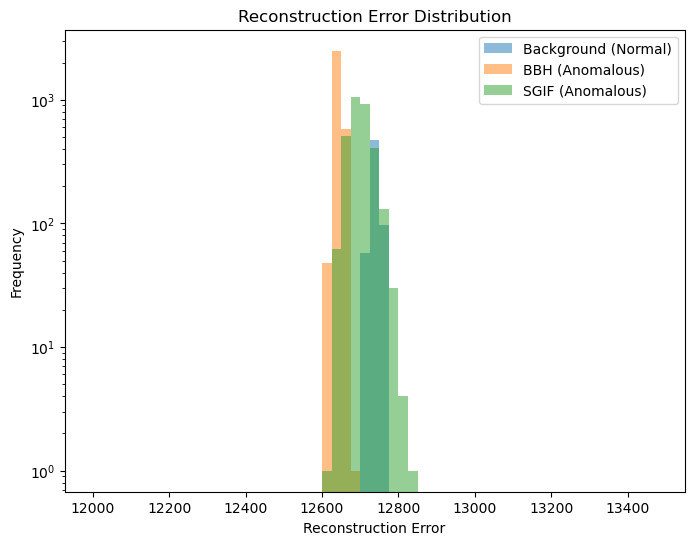

In [13]:
plt.figure(figsize=(8, 6))
bins = list(range(12000, 13500, 25))
plt.hist(background_errors, bins=bins, alpha=0.5, label="Background (Normal)")
plt.hist(bbh_errors, bins=bins, alpha=0.5, label="BBH (Anomalous)")
plt.hist(sglf_errors, bins=bins, alpha=0.5, label="SGIF (Anomalous)")
plt.yscale("log")  # Log scale
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

In [14]:
def plot_roc_curve(normal_errors, anomaly_errors, title="ROC Curve"):
    true_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
    scores = np.concatenate([normal_errors, anomaly_errors])

    fpr, tpr, _ = roc_curve(true_labels, scores)
    print(true_labels)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

[0. 0. 0. ... 1. 1. 1.]


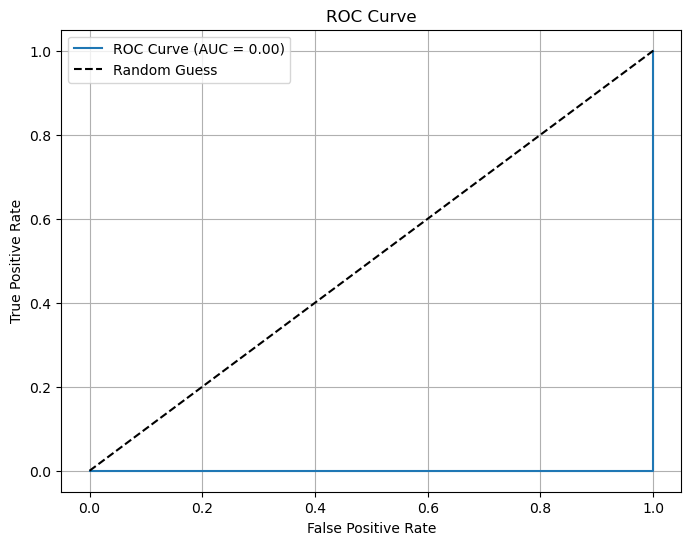

In [15]:
plot_roc_curve(background_errors, bbh_errors)

[0. 0. 0. ... 1. 1. 1.]


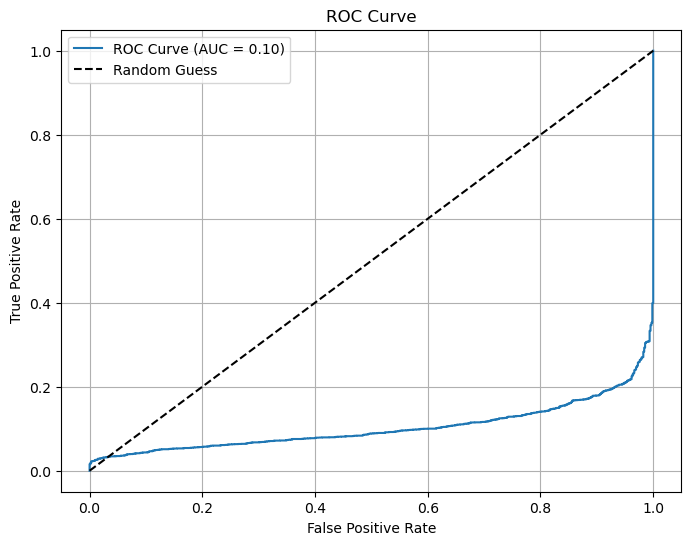

In [16]:
plot_roc_curve(background_errors, sglf_errors)

In [17]:
# test_rec_loss, test_kl_loss, test_total_loss = compute_reconstruction_errors(model, x_test)
# sglf_rec_loss, sglf_kl_loss, sglf_total_loss = compute_reconstruction_errors(model, sglf)
# bbh_rec_loss, bbh_kl_loss, bbh_total_loss = compute_reconstruction_errors(model, bbh)

# print(f"Test Set - Reconstruction Loss: {test_rec_loss}, KL Divergence: {test_kl_loss}, Total Loss: {test_total_loss}")
# print(f"SGLF Set - Reconstruction Loss: {sglf_rec_loss}, KL Divergence: {sglf_kl_loss}, Total Loss: {sglf_total_loss}")
# print(f"BBH Set - Reconstruction Loss: {bbh_rec_loss}, KL Divergence: {bbh_kl_loss}, Total Loss: {bbh_total_loss}")

In [18]:
# model_name = "VAE_increased_zdim_40_wd"

In [19]:
# def log_model_results(model_name, z_dim, batch_size, epochs, lr_rate, weight_decay, test_rec_loss, test_kl_loss, test_total_loss, sglf_rec_loss, sglf_kl_loss, sglf_total_loss, bbh_rec_loss, bbh_kl_loss, bbh_total_loss, file_name="vae_model_results.csv"):
#     log_entry = {
#         "model_name": model_name,
#         "z_dim": z_dim,
#         "batch_size": batch_size,
#         "epochs": epochs,
#         "lr_rate": lr_rate,
#         "weight_decay": weight_decay,
#         "test_rec_loss": test_rec_loss,
#         "test_kl_loss": test_kl_loss,
#         "test_total_loss": test_total_loss,
#         "sglf_rec_loss": sglf_rec_loss,
#         "sglf_kl_loss": sglf_kl_loss, 
#         "sglf_total_loss": sglf_total_loss, 
#         "bbh_rec_loss": bbh_rec_loss, 
#         "bbh_kl_loss": bbh_kl_loss, 
#         "bbh_total_loss": bbh_total_loss,
#     }
    
#     file_exists = False
#     try:
#         with open(file_name, mode='r', newline='') as file:
#             file_exists = True 
#     except FileNotFoundError:
#         file_exists = False 

#     with open(file_name, mode='a', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=log_entry.keys())
#         if not file_exists:
#             writer.writeheader()
#         writer.writerow(log_entry)

In [20]:
# log_model_results(model_name, z_dim, batch_size, num_epochs, lr_rate, weight_decay, test_rec_loss, test_kl_loss, test_total_loss, sglf_rec_loss, sglf_kl_loss, sglf_total_loss, bbh_rec_loss, bbh_kl_loss, bbh_total_loss)